# Manhattan Crime Data Analysis

Currently, I have included Manhattan crime data for years 2008-2016.
I will Update once I get the 2017 data.

The Following Analysis is over the historic data. I will include Crime Forecasting by next week.

I will be updating the notebook with more text explanation.

In [1]:
## Importing all the required Python Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import calendar
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Import

In [2]:
crimes = pd.read_csv('./NYPD_Complaint_Data_Historic.csv',error_bad_lines=False)
#crimes_2016-17 = pd.read_csv('./crimes_2016-17.csv',error_bad_lines=False)
#crimes = pd.concat([crimes1, crimes_2016-17], ignore_index=False, axis=0)
#del crimes1
#del crimes_2016-17
print('Dataset Shape before cleaning records and drop_duplicate : ')
crimes.info()

Dataset Shape before cleaning records and drop_duplicate : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331760 entries, 0 to 1331759
Data columns (total 24 columns):
CMPLNT_NUM           1331760 non-null int64
CMPLNT_FR_DT         1331618 non-null object
CMPLNT_FR_TM         1331748 non-null object
CMPLNT_TO_DT         966834 non-null object
CMPLNT_TO_TM         967664 non-null object
RPT_DT               1331760 non-null object
KY_CD                1331760 non-null int64
OFNS_DESC            1325627 non-null object
PD_CD                1331100 non-null float64
PD_DESC              1331100 non-null object
CRM_ATPT_CPTD_CD     1331757 non-null object
LAW_CAT_CD           1331760 non-null object
JURIS_DESC           1331760 non-null object
BORO_NM              1331760 non-null object
ADDR_PCT_CD          1331758 non-null float64
LOC_OF_OCCUR_DESC    1046918 non-null object
PREM_TYP_DESC        1320564 non-null object
PARKS_NM             4264 non-null object
HADEVELOPT           5

## Data Cleansing

#### (PENDING)Task: Replace CMPNT_FR_DT with RPT_DT for all missing values
#### (PENDING)Task: Fill up values for OFNS_DESC based on previous KY_CD - OFNS_DESC Pairs

##### For now removing rows with missing values for specified columns

In [3]:
crimes=crimes.dropna(subset = ['CMPLNT_FR_DT','OFNS_DESC','PREM_TYP_DESC'])

#We will not be using following columns for now (primary analysis) 
crimes.drop(['CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM','PD_CD','BORO_NM','LOC_OF_OCCUR_DESC','PARKS_NM', 'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon'], inplace=True, axis=1)
crimes.drop_duplicates(subset=['CMPLNT_NUM'],inplace=True)

# Including Year and MOnth Column for time plots 
crimes['Year'] = crimes['RPT_DT'].apply(lambda x: str(x.split()[0].split('/')[2]))
crimes['MonthNo'] = crimes['RPT_DT'].apply(lambda x: str(x.split()[0].split('/')[0]))
monthDict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes['Month'] = crimes['MonthNo'].apply(lambda x: monthDict[x])
crimes.Year=pd.to_numeric(crimes.Year)

#Removing records before 2008 as most of them are incomplete and records are missing for complete year
crimes = pd.DataFrame(crimes[crimes['Year'] >= 2008])


print('Cleansed Dataset with new month and year column')
print('Dataset Shape',crimes.shape)
crimes.head()

Cleansed Dataset with new month and year column
Dataset Shape (1058711, 14)


,CMPLNT_NUM,CMPLNT_FR_DT,RPT_DT,KY_CD,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,JURIS_DESC,ADDR_PCT_CD,PREM_TYP_DESC,Year,MonthNo,Month
0,569369778,12/31/2015,12/31/2015,117,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,FELONY,N.Y. POLICE DEPT,28.0,OTHER,2015,12,Dec
1,641637920,12/31/2015,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,13.0,OTHER,2015,12,Dec
2,608231454,12/31/2015,12/31/2015,235,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE, POSSESSI",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,7.0,STREET,2015,12,Dec
3,415095955,12/31/2015,12/31/2015,341,PETIT LARCENY,"LARCENY,PETIT FROM BUILDING,UN",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,19.0,DRUG STORE,2015,12,Dec
4,178090167,12/31/2015,12/31/2015,341,PETIT LARCENY,"LARCENY,PETIT FROM BUILDING,UN",COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,13.0,RESTAURANT/DINER,2015,12,Dec


As there are many categorical variables, 
for ex: 

'OFNS_DESC' we will select 20 frequetly occured crime categories and all others as one category 'OTHER'

'PREM_TYP_DESC' we will select 20 most frequet crime scenes and all others as one category 'OTHER'

In [4]:
offense_desc = list(crimes['OFNS_DESC'].value_counts()[20:].index)
locations  = list(crimes['PREM_TYP_DESC'].value_counts()[20:].index)
crimes.loc[crimes['PREM_TYP_DESC'].isin(locations) , crimes.columns=='PREM_TYP_DESC'] = 'OTHER'
crimes.loc[crimes['OFNS_DESC'].isin(offense_desc) , crimes.columns=='OFNS_DESC'] = 'OTHER'

#Changing variables to categorical type
crimes['OFNS_DESC']         = pd.Categorical(crimes['OFNS_DESC'])
crimes['PREM_TYP_DESC'] = pd.Categorical(crimes['PREM_TYP_DESC'])

## Total Crimes 
How many unique crime categories are available and what is the count for each crime category from 2008-2016?

In [5]:
# Group by Crime type and calculate count
crime_count = pd.DataFrame(crimes.groupby('OFNS_DESC').size().sort_values(ascending=False).rename('Count').reset_index())

print('\n Total Categories of Crimes::',len(crime_count.index))

# Top 10 crimes categories
print('\n Top 10 categories of frequently occured crimes \n\n',crime_count.head(10))

#Ploting the top 20 crimes as barplot
print('\n Plot of top 20 crime categories \n')
crime_count[:20].plot(x='OFNS_DESC',y='Count',kind='bar')


 Total Categories of Crimes:: 21

 Top 10 categories of frequently occured crimes 

                         OFNS_DESC   Count
0                   PETIT LARCENY  230585
1                   GRAND LARCENY  144030
2                   HARRASSMENT 2  106627
3    ASSAULT 3 & RELATED OFFENSES   89221
4  CRIMINAL MISCHIEF & RELATED OF   81160
5                 DANGEROUS DRUGS   68114
6   OFF. AGNST PUB ORD SENSBLTY &   48453
7                           OTHER   47075
8                         ROBBERY   31561
9                  FELONY ASSAULT   29935

 Plot of top 20 crime categories 



## Crime Locations

In [6]:
# Group by Crime Location and calculate count
crime_location = pd.DataFrame(crimes.groupby('PREM_TYP_DESC').size().sort_values(ascending=False).rename('Count').reset_index())
print('\n Total types of crime location::',len(crime_location.index))

# Top 10 crime clocation and their counts
print('\n Top 10 crime locations \n\n',crime_location.head(10))


 Total types of crime location:: 20

 Top 10 crime locations 

                 PREM_TYP_DESC   Count
0                      STREET  298740
1      RESIDENCE - APT. HOUSE  194067
2                       OTHER  109503
3  RESIDENCE - PUBLIC HOUSING  105181
4         COMMERCIAL BUILDING   46399
5        TRANSIT - NYC SUBWAY   45952
6                 CHAIN STORE   37976
7            DEPARTMENT STORE   37708
8              BAR/NIGHT CLUB   29920
9            RESTAURANT/DINER   26677


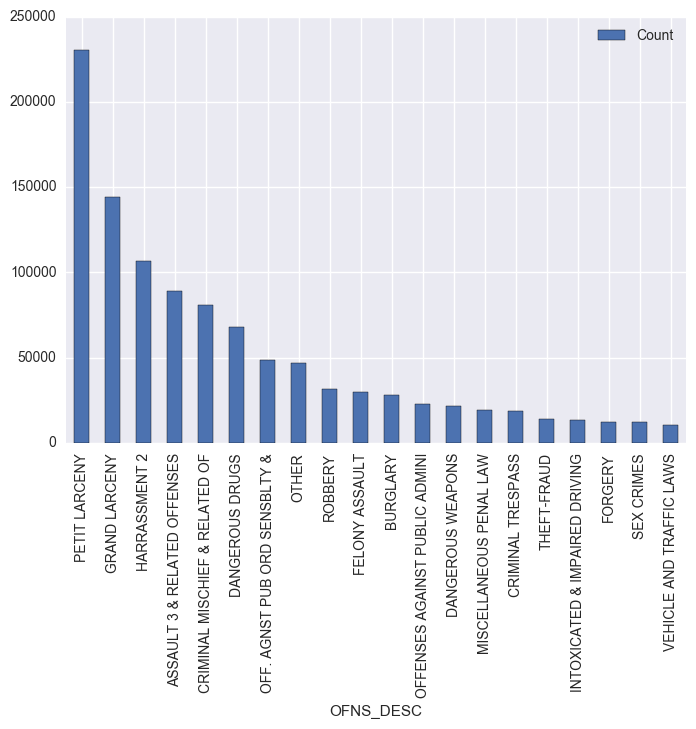

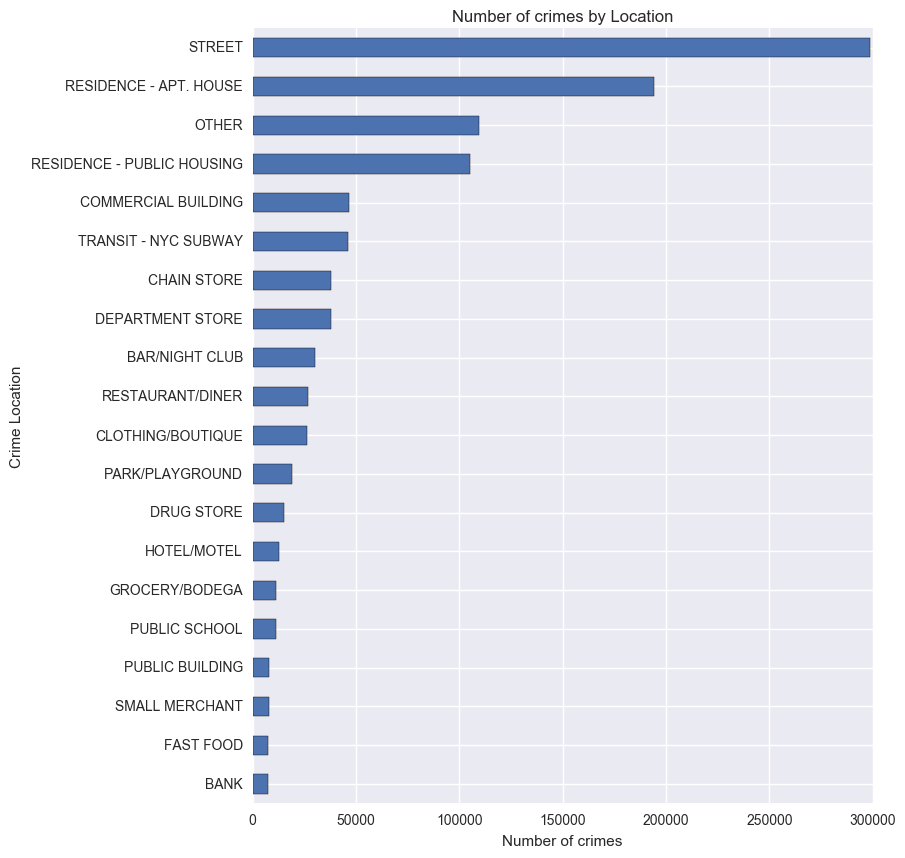

In [7]:
#Ploting 
plt.figure(figsize=(8,10))
crimes.groupby([crimes['PREM_TYP_DESC']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

## Crime Activity Analysis(Rate)

In [8]:
#HeatMap of Crime_Activity by year and month 
crime_activity_plot = pd.DataFrame(crimes.groupby(['Month','Year']).size().sort_values(ascending=False).rename('Count').reset_index())
crime_activity_plot.head()
crime_activity_plot_2008_2015 = crime_activity_plot.pivot_table(values='Count',index='Month',columns='Year')
sns.heatmap(crime_activity_plot_2008_2015)

From the above matrixplot following observations were made:
2008 and 2009 had the highest crime activity in the 9 year period
Also, through out the time period, July and August had the highest crime activity

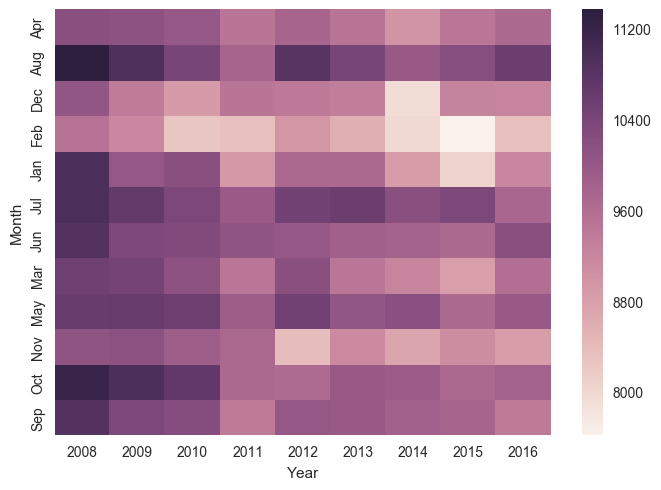

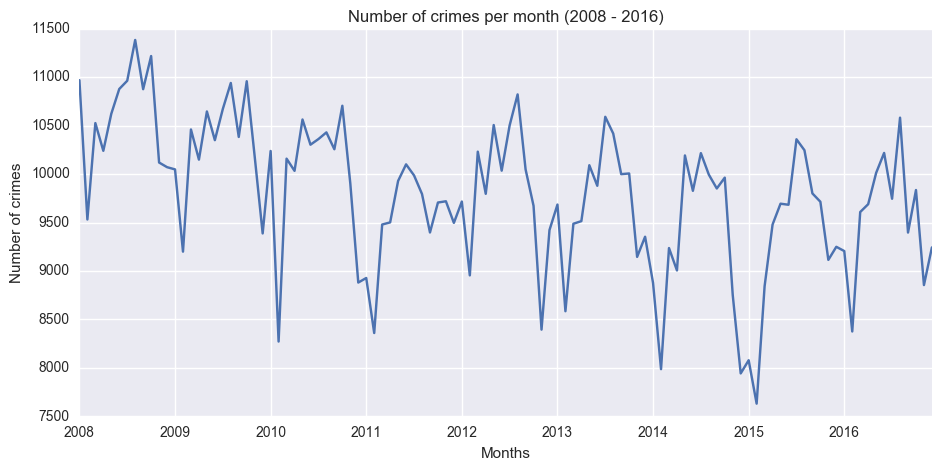

In [9]:
# setting the index to be the date for time respective ploting purpose
crimes.index = pd.DatetimeIndex(crimes.RPT_DT)

#Plot the monthly Crime timeline from 2008 - 2016
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2008 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

Above graph shows a clear "periodic" pattern in the monthly crimes over 9 years. Certainly many conclusions can be drawn from above graph. For example, the crime pattern shows decrease in crime around the end of each year and start of new year.

Crime is a very predictable activity!

How crime has changed over the years?
 
In a previous chart, we already looked at the number of monthly crime records. 

Here, we will look at the rolling sum of crimes of the past years. 
For each day, we calculate the sum of crimes of the past year. If this rolling sum is decreasing, then crime rates have been decreasing during that year. On the contrary, if the rolling sum stays the same during a given year, then it implies that crime rates stayed the same.

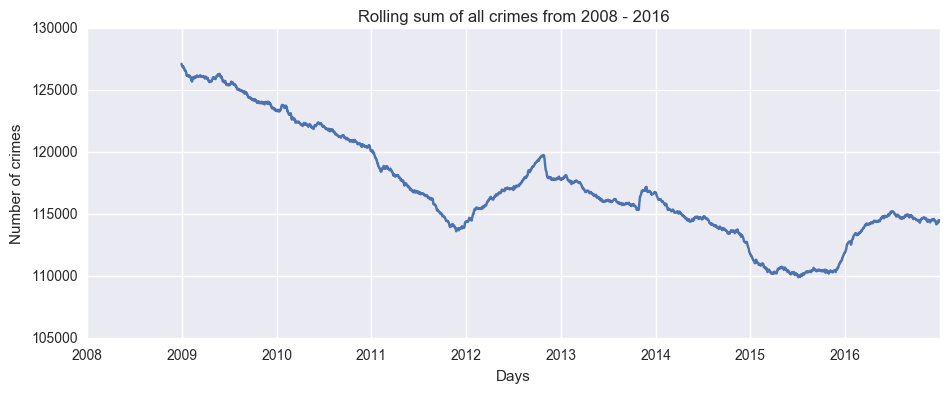

In [10]:
# Rolling Sum Plot
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2008 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

We can see that the crime rate decreased over years from 2009 to 2012 and 2013-2015. Unfortunately  it has increased during 2012 and 2016 calender years. 

But this is for total crimes.

## Lets explore the major crimes types and their frequencies over the timeline

In [11]:
crimes_count_date = crimes.pivot_table('CMPLNT_NUM', aggfunc=np.size, columns='OFNS_DESC', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

## Exploring crimes over the week days

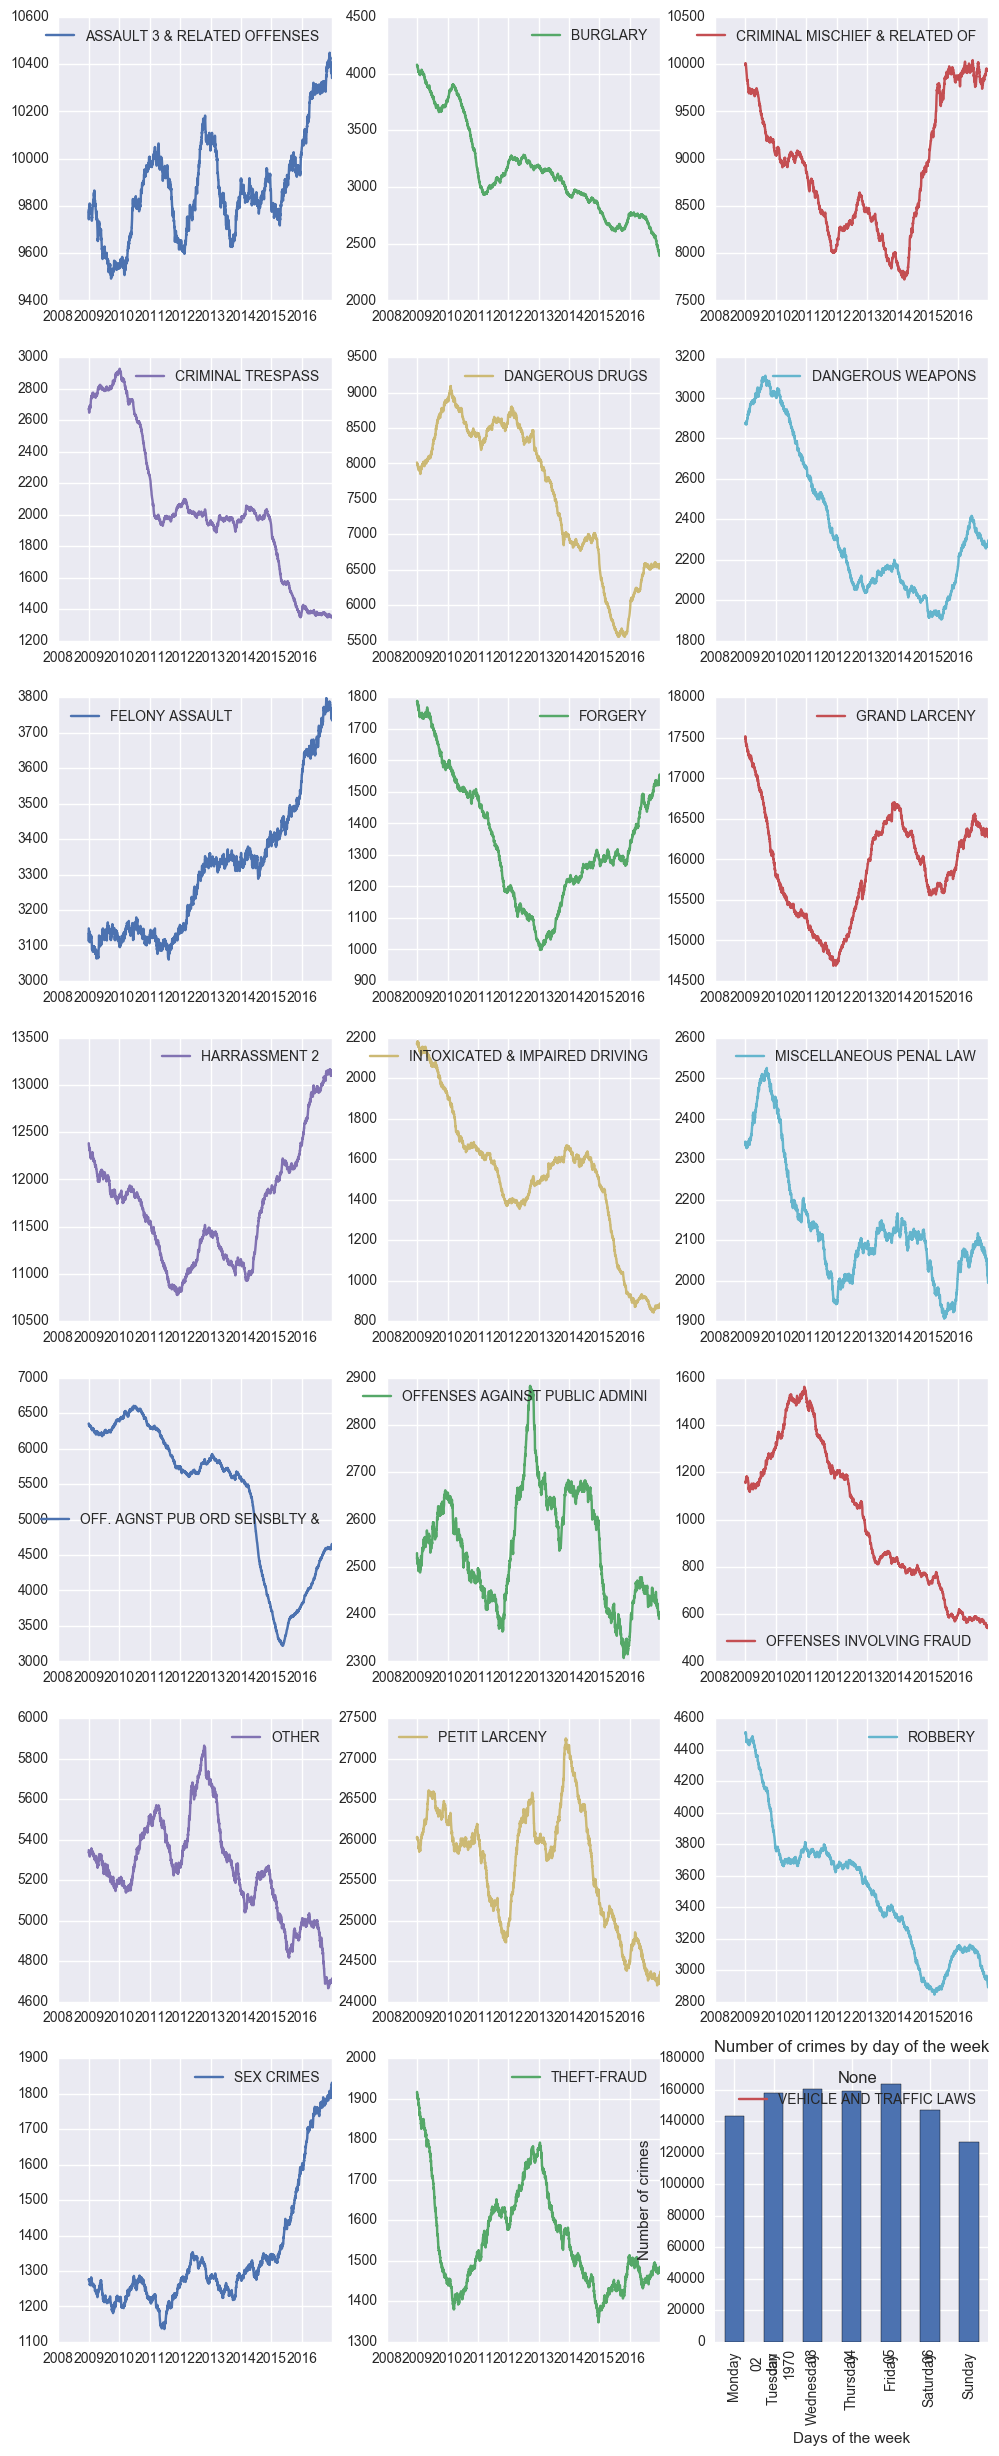

In [12]:
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='bar')
plt.ylabel('Number of crimes')
plt.xticks(np.arange(7), days)
plt.xlabel('Days of the week')
plt.title('Number of crimes by day of the week')
plt.show()

We know that all crimes are not the same. 
Few crime types are more likely to occur than others depending on the place and time.

In this section, we will see how crimes differ based on different locations and week days.


In [13]:
dayofweek_by_location = crimes.pivot_table(values='CMPLNT_NUM', index='PREM_TYP_DESC', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='CMPLNT_NUM', index='OFNS_DESC', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='CMPLNT_NUM', index='PREM_TYP_DESC', columns='OFNS_DESC', aggfunc=np.size).fillna(0)

# IN PROGRESS
Below part is in progress as the graphs are not generating properly due to incorrect data issue.

#### (Pending) Task: Use Agglomerative clustering to group crime by type and location, location and week days

In [14]:

from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

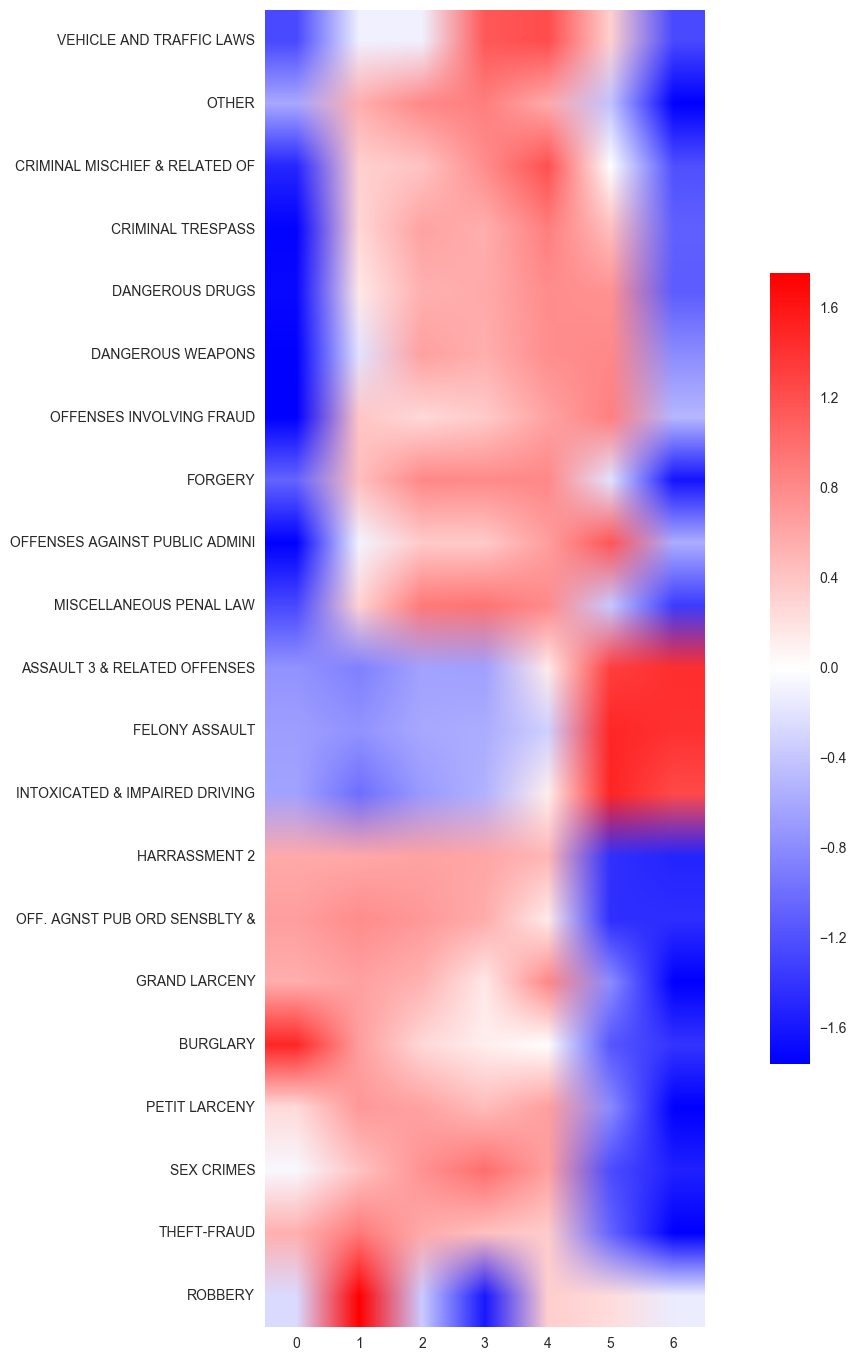

In [15]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)

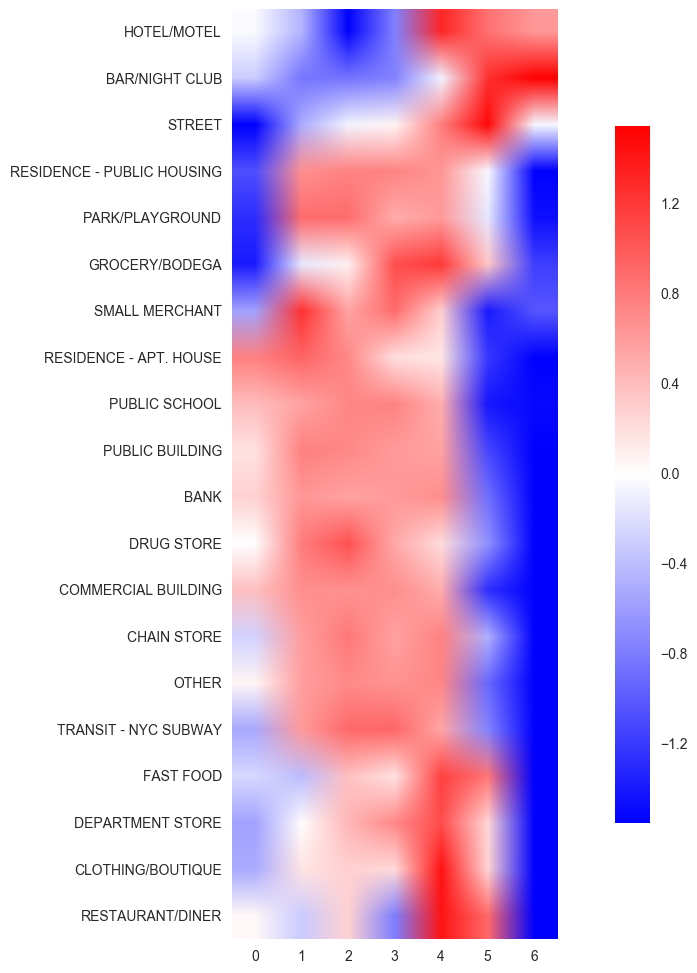

In [16]:
plt.figure(figsize=(15,12))
scale_and_plot(dayofweek_by_location)

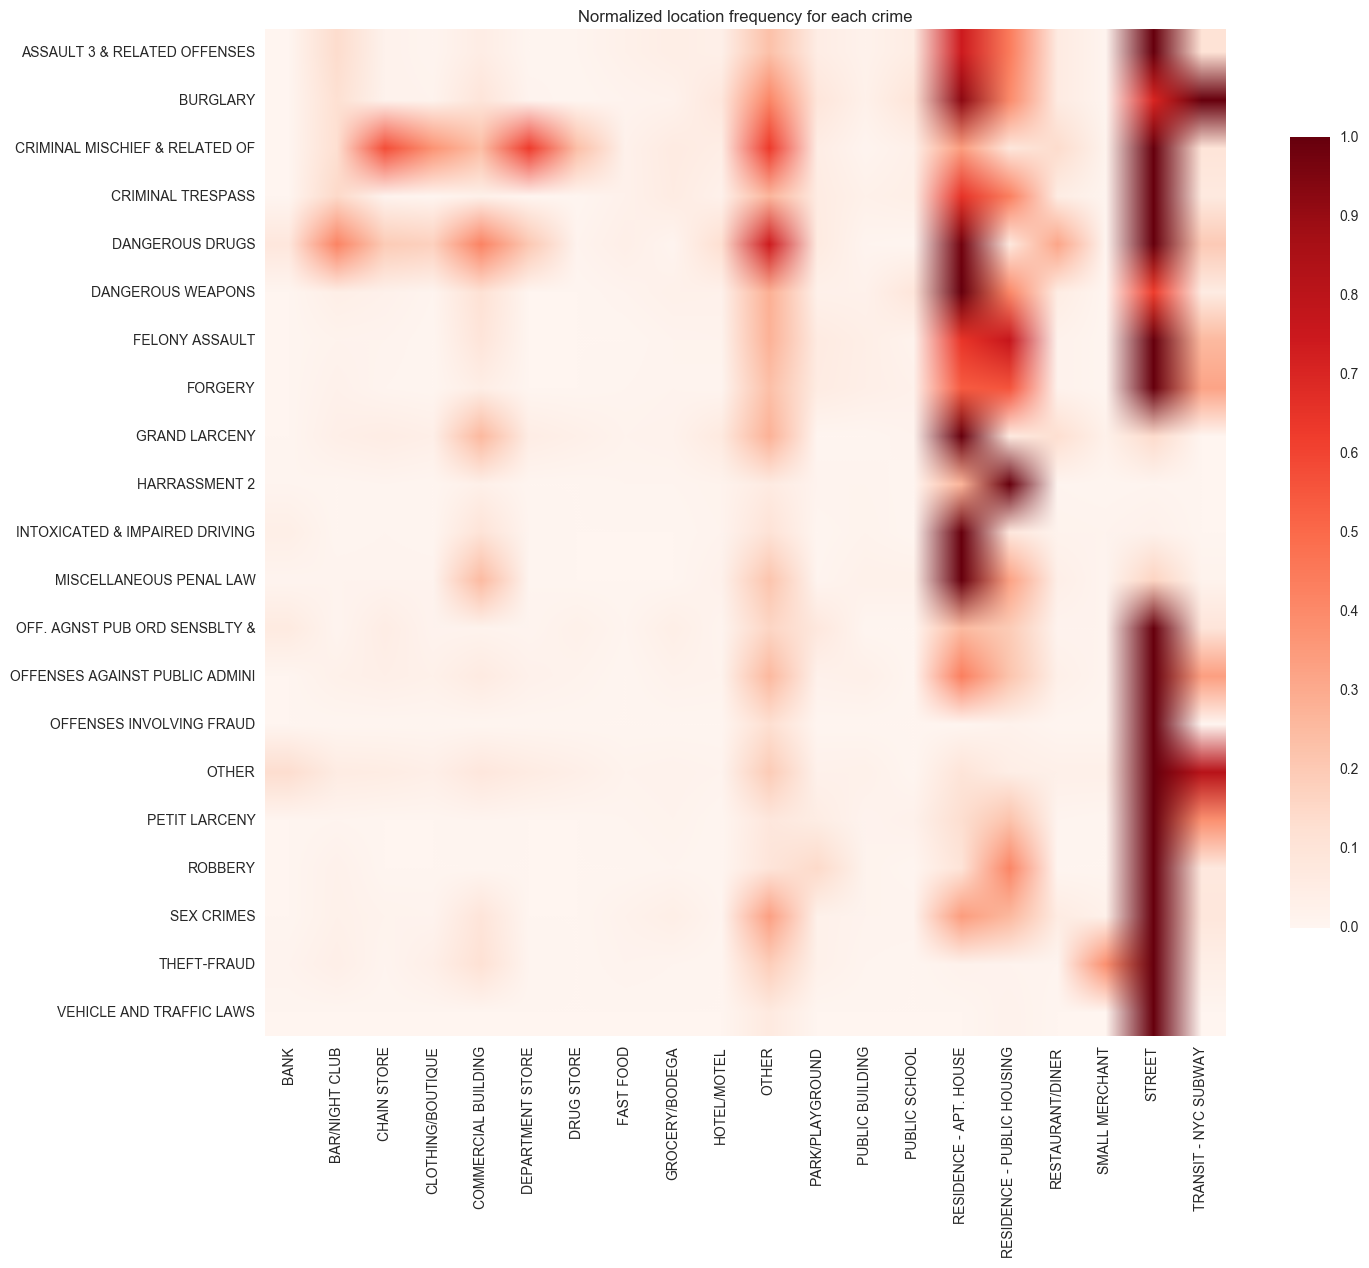

In [17]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()